In [1]:
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from functions import * # my custom functions 
import scib
import pickle

# rpy2 for running R code|
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR) # Ignore R warning messages
import rpy2.robjects as ro
import anndata2ri

# scanpy config
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
# sns.set_style("ticks")
sc.settings.set_figure_params(frameon=False, dpi_save=1000)

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


scanpy==1.8.2 anndata==0.8.0 umap==0.5.1 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.23.2 statsmodels==0.13.0 python-igraph==0.9.6 louvain==0.7.0 pynndescent==0.5.5


/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/umap/__init__.py:11: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  category=ImportWarning


In [12]:
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['platform']=platform.system()
        info['platform-release']=platform.release()
        info['platform-version']=platform.version()
        info['architecture']=platform.machine()
        info['processor']=platform.processor()
        info['ram']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'platform': 'Linux',
 'platform-release': '4.18.0-373.el8.x86_64',
 'platform-version': '#1 SMP Tue Mar 22 15:11:47 UTC 2022',
 'architecture': 'x86_64',
 'processor': 'x86_64',
 'ram': '378 GB'}

In [13]:
MY_PALETTES = dict(
    deep=["#4C72B0", "#DD8452", "#55A868", "#C44E52", "#8172B3",
          "#937860", "#DA8BC3", "#b5bd61", "#CCB974", "#64B5CD"],
    deep6=["#4C72B0", "#55A868", "#C44E52",
           "#8172B3", "#CCB974", "#64B5CD"],
    muted=["#4878D0", "#EE854A", "#6ACC64", "#D65F5F", "#956CB4",
           "#8C613C", "#DC7EC0", "#797979", "#D5BB67", "#82C6E2"],
    muted6=["#4878D0", "#6ACC64", "#D65F5F",
            "#956CB4", "#D5BB67", "#82C6E2"],
    pastel=["#A1C9F4", "#FFB482", "#8DE5A1", "#FF9F9B", "#D0BBFF",
            "#DEBB9B", "#FAB0E4", "#CFCFCF", "#FFFEA3", "#B9F2F0"],
    pastel6=["#A1C9F4", "#8DE5A1", "#FF9F9B",
             "#D0BBFF", "#FFFEA3", "#B9F2F0"],
    bright=["#023EFF", "#FF7C00", "#1AC938", "#E8000B", "#8B2BE2",
            "#9F4800", "#F14CC1", "#A3A3A3", "#FFC400", "#00D7FF"],
    bright6=["#023EFF", "#1AC938", "#E8000B",
             "#8B2BE2", "#FFC400", "#00D7FF"],
    dark=["#001C7F", "#B1400D", "#12711C", "#8C0800", "#591E71",
          "#592F0D", "#A23582", "#3C3C3C", "#B8850A", "#006374"],
    dark6=["#001C7F", "#12711C", "#8C0800",
           "#591E71", "#B8850A", "#006374"],
    colorblind=["#0173B2", "#DE8F05", "#029E73", "#D55E00", "#CC78BC",
                "#CA9161", "#FBAFE4", "#949494", "#ECE133", "#56B4E9"],
    colorblind6=["#0173B2", "#029E73", "#D55E00",
                 "#CC78BC", "#ECE133", "#56B4E9"]
)

# Meta Marker analysis

In [14]:
atlas = sc.read_h5ad("/exports/humgen/cnovellarausell/KidneyAtlas/h5ad/atlas_full_SCVI_annotated_v3.h5ad")

In [15]:
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:264: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  category=DeprecationWarning)
/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/rpy2/robjects/numpy2ri.py:188: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  category=DeprecationWarning)


In [16]:
%%R
.libPaths( c( .libPaths(), "/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/R/library") )

In [17]:
%%R -i atlas

library(MetaMarkers)

park <- subset(atlas, , Origin=='Park18')
susztak <- subset(atlas, , Origin='Miao21')
kirita <- subset(atlas, , Origin=='Kirita20')
wu <- subset(atlas, , Origin=='Wu19')
dumas <- subset(atlas, , Origin=='Dumas20')
hinze_scell <- subset(atlas, , Origin=='Hinze20')
conway <- subset(atlas, , Origin=='Conway20')
janosevic <- subset(atlas, , Origin=='Janosevic21')

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/anndata2ri/r2py.py:102: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


In [18]:
%%R
markers_all = list(
    park = compute_markers(convert_to_cpm(assay(park, "counts")), park$Predicted_Celltype_all),
    susztak = compute_markers(convert_to_cpm(assay(susztak, "counts")), susztak$Predicted_Celltype_all),
    kirita = compute_markers(convert_to_cpm(assay(kirita, "counts")), kirita$Predicted_Celltype_all),
    wu = compute_markers(convert_to_cpm(assay(wu, "counts")), wu$Predicted_Celltype_all),
    hinze_scell = compute_markers(convert_to_cpm(assay(hinze_scell, "counts")), hinze_scell$Predicted_Celltype_all),
    dumas = compute_markers(convert_to_cpm(assay(dumas, "counts")), dumas$Predicted_Celltype_all),
    conway = compute_markers(convert_to_cpm(assay(conway, "counts")), conway$Predicted_Celltype_all),
    janosevic = compute_markers(convert_to_cpm(assay(janosevic, "counts")), janosevic$Predicted_Celltype_all)
)



In [19]:
%%R

meta_markers_all = make_meta_markers(markers_all, detailed_stats = TRUE)

In [20]:
%%R
export_markers(markers_all$park, 'markers_park.csv')
export_markers(markers_all$susztak, 'markers_susztak.csv')
export_markers(markers_all$kirita, 'markers_kirita.csv')
export_markers(markers_all$wu, 'markers_wu.csv')
export_markers(markers_all$hinze_scell, 'markers_hinze.csv')
export_markers(markers_all$dumas, 'markers_dumas.csv')
export_markers(markers_all$conway, 'markers_conway.csv')
export_markers(markers_all$janosevic, 'markers_janosevic.csv')

In [21]:
%%R
export_meta_markers(meta_markers_all, "meta_markers_SCVI.csv", names(markers_all))

In [22]:
%%R
library(ggplot2)

celltypes <- unique(meta_markers_all$cell_type)
celltypes <- celltypes[!celltypes %in% 'root']
myplots <- lapply(celltypes, plot_pareto_markers, meta_markers = meta_markers_all)
pdf("plots_SCVI_metamarkers.pdf")
for (i in seq(length(myplots))) {
    print(myplots[[i]] + ggtitle(celltypes[i]) + theme_classic())
}
dev.off()


[1] 2


In [43]:
meta_markers = pd.read_csv('/exports/humgen/cnovellarausell/KidneyAtlas/metamarkers/meta_markers_SCVI.csv',skiprows=1, sep=';')

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (13,15,16,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:
pareto_genes = []
min_recurrence = 2

for ct in meta_markers.cell_type.unique():
    find_pareto = meta_markers.query('recurrence >= @min_recurrence & cell_type == @ct')
    front = find_pareto[['auroc','fold_change_detection']].sort_values(['auroc','fold_change_detection'], ascending=[False,False])
    par_genes = find_pareto[front.fold_change_detection >= np.maximum.accumulate(front.fold_change_detection)].sort_values('fold_change_detection')
    pareto_genes.append(par_genes)
pareto_genes
pareto_genes_all = pd.concat(pareto_genes)
pareto_genes_all.to_csv("pareto_markers.csv")

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/exports/humgen

In [26]:
pareto_genes = []
min_recurrence = 2
meta_markers = meta_markers[meta_markers.cell_type.isin(['DCT-CNT', 'DTL-ATL', 'PTS3T2', 'Podo', 'CD-Trans'])]

for ct in meta_markers.cell_type.unique():
    find_pareto = meta_markers.query('recurrence >= @min_recurrence & cell_type == @ct')
    front = find_pareto[['auroc','fold_change_detection']].sort_values(['auroc','fold_change_detection'], ascending=[False,False])
    par_genes = find_pareto[front.fold_change_detection >= np.maximum.accumulate(front.fold_change_detection)].sort_values('fold_change_detection')
    pareto_genes.append(par_genes)
pareto_genes = pd.concat(pareto_genes)

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/exports/humgen/cnovellarausell/conda_envs/at

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


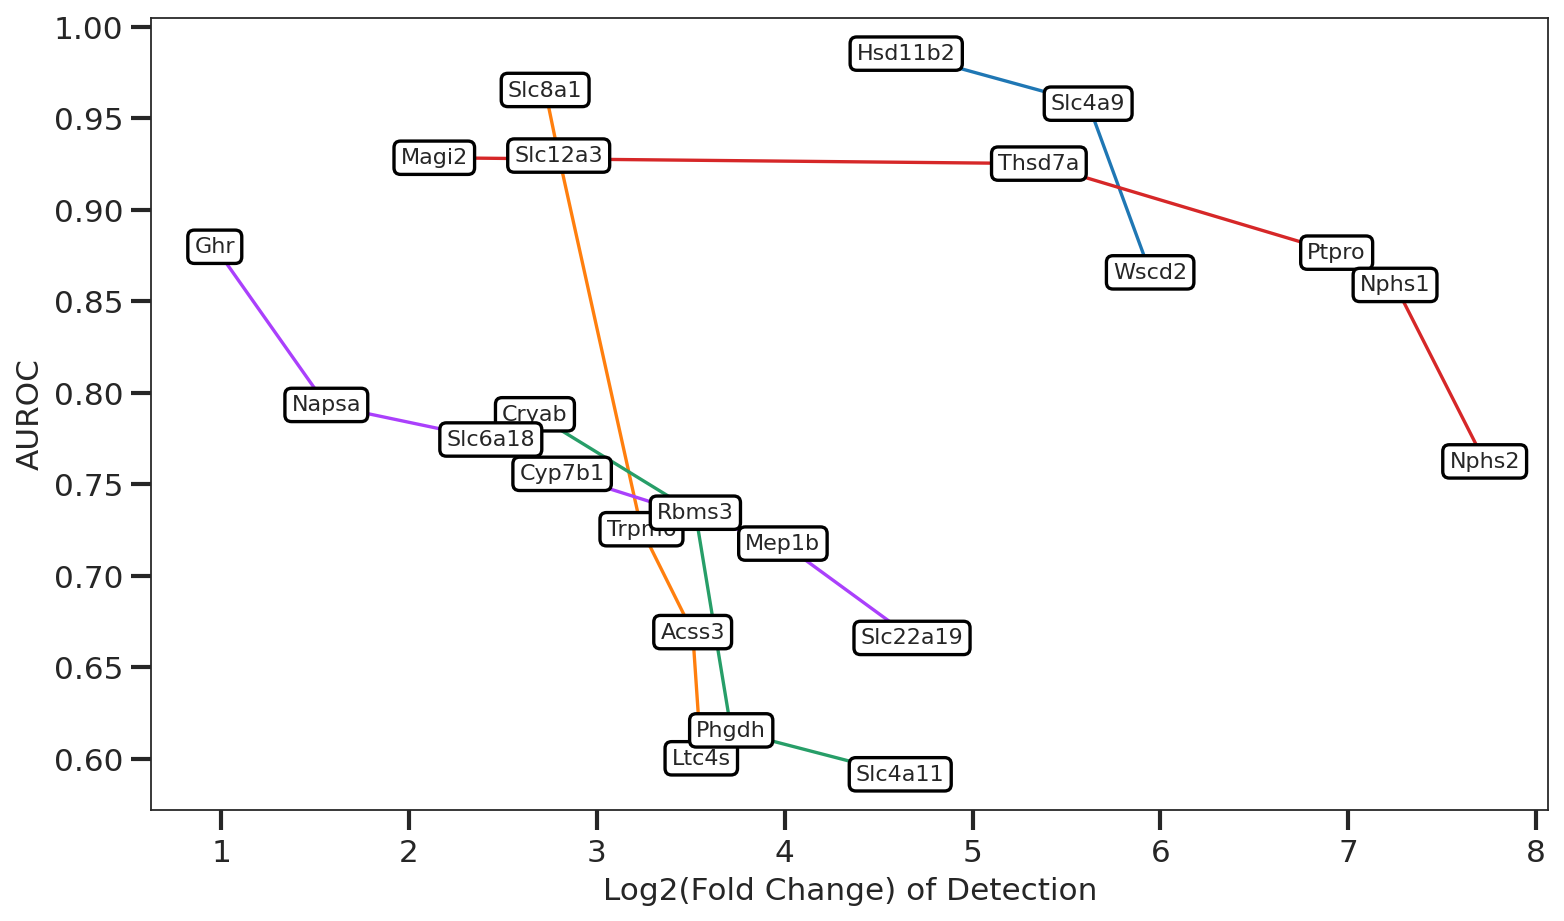

In [27]:
sns.set_style("ticks", {'axes.grid' : False})
fig ,ax = plt.subplots(figsize=(10,6))
ax = sns.lineplot(x=np.log2(pareto_genes.fold_change_detection),
                     y=pareto_genes.auroc,
                     hue=pareto_genes.cell_type,
                     sort=False,
                     legend=None)
#ax.legend(loc=(1,0),frameon=False)
ax.set(xlabel='Log2(Fold Change) of Detection',
      ylabel='AUROC')
for row in pareto_genes.itertuples():
    ax.text(np.log2(row.fold_change_detection),
             row.auroc , 
        row.gene, 
        size=10,
        ha='center',
        va='center',
        bbox=dict(boxstyle='round',
                  facecolor='white',
                  edgecolor='black'
))
plt.tight_layout()
plt.savefig('top_marker_pareto.pdf',
            transparent=True)

In [28]:
top3 = pareto_genes_all.groupby('cell_type').head(3)[['gene', 'cell_type']]
top3_dd = top3.groupby('cell_type').apply(lambda x: x.drop('cell_type',  axis=1).to_dict(orient='list')).to_dict()
top3_d = {}
for subkey, subvalue in top3_dd.items():              
    for key, value in subvalue.items():  
        top3_d.setdefault(subkey, []).extend(value)

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
metamarker_mappings = {key: value for key, value in top3_d.items() if key in  ['PTS1', 'PTS2', 'PTS3', 'PTS3T2', 'Podo' ,'CTAL', 'MTAL', 'DTL', 'DTL-ATL', 'ATL', 'CNT', 'DCT', 'DCT-CNT', 'ICA', 'ICB', 'CD-Trans']}
metamarker_mappings = {k: metamarker_mappings[k] for k in ['PTS1', 'PTS2', 'PTS3', 'PTS3T2', 'Podo' ,'CTAL', 'MTAL', 'ATL', 'DTL', 'DTL-ATL',  'CNT', 'DCT', 'DCT-CNT', 'ICA', 'ICB', 'CD-Trans']}

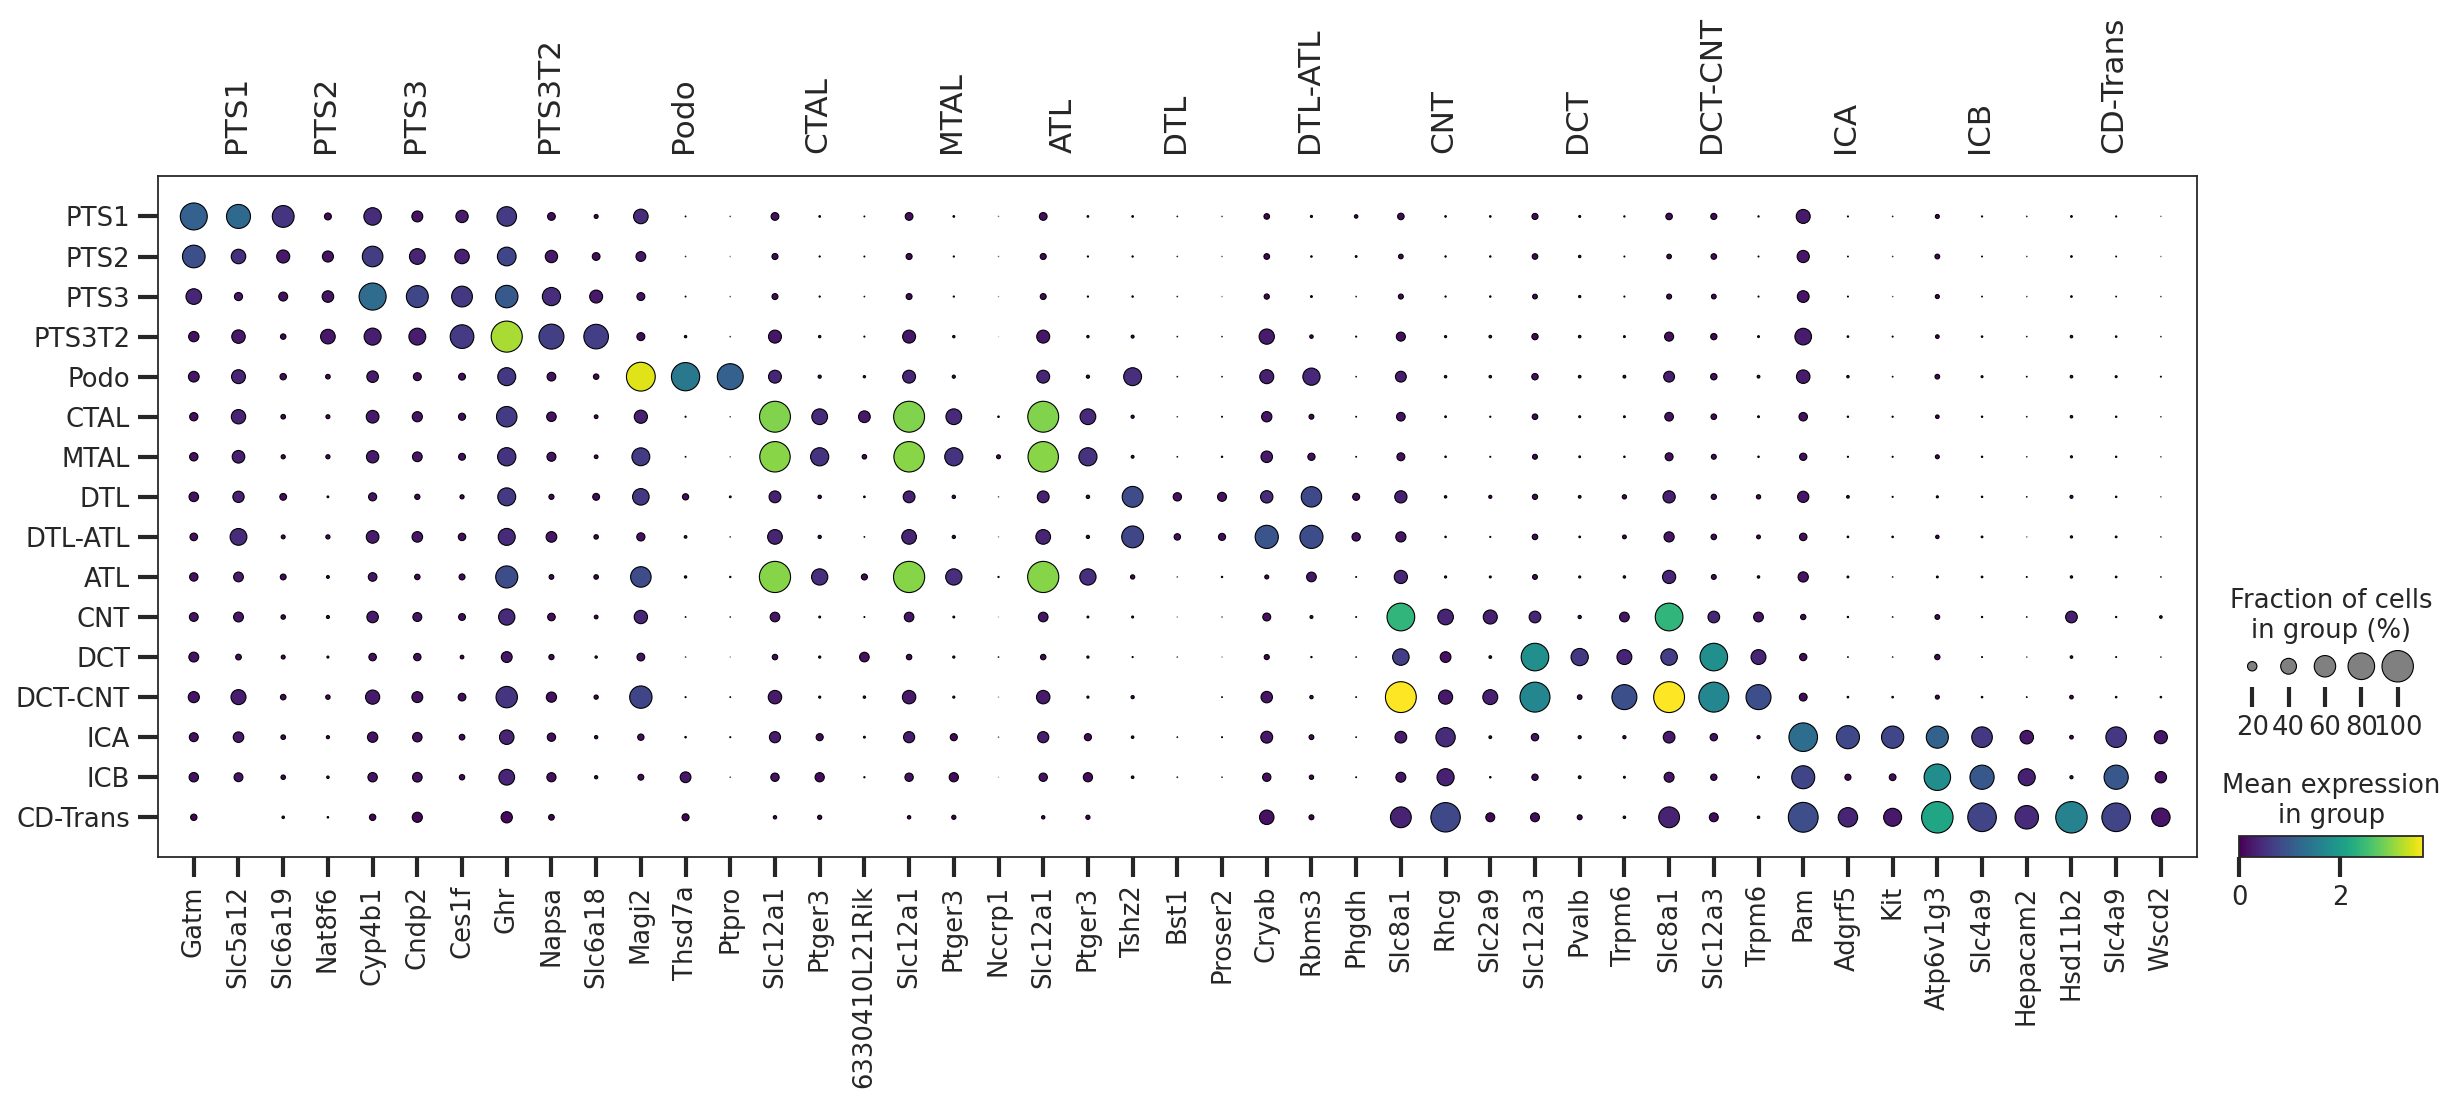

In [30]:
sc.pl.DotPlot(atlas[atlas.obs['Predicted_Celltype_all'].isin(['PTS1', 'PTS2', 'PTS3', 'PTS3T2', 'Podo' ,'CTAL', 'MTAL', 'DTL', 'DTL-ATL', 'ATL', 'CNT', 'DCT', 'DCT-CNT', 'ICA', 'ICB', 'CD-Trans'])], metamarker_mappings, groupby='Predicted_Celltype_all', var_group_rotation = 90, categories_order = ['PTS1', 'PTS2', 'PTS3', 'PTS3T2', 'Podo' ,'CTAL', 'MTAL', 'DTL', 'DTL-ATL', 'ATL', 'CNT', 'DCT', 'DCT-CNT', 'ICA', 'ICB', 'CD-Trans'] ).style( dot_edge_color='black', dot_edge_lw=0.5, cmap='viridis').savefig('metamarkers_dotplot_SCVI.pdf')

# Fisher comparisons with Chen et al. 2021

-  Paper: **https://pubmed.ncbi.nlm.nih.gov/33769951//**
- To generate Figure 5B, take a look at this [R Mardown](MM_comparison_Chen2021.Rmd)

## MetaMarkers

In [ ]:
atlas = sc.read_h5ad("/exports/humgen/cnovellarausell/KidneyAtlas/h5ad/atlas_full_SCVI_annotated_v3.h5ad")
meta_markers = pd.read_csv('/exports/humgen/cnovellarausell/KidneyAtlas/metamarkers/meta_markers_SCVI.csv.gz', skiprows=1)
degs_md = pd.read_excel("/exports/humgen/cnovellarausell/KidneyAtlas/degs/MicroDiss-RNAseqSupplementaryData4.xlsx", sheet_name=None)

In [ ]:
for key in degs_md.keys():
    degs_md[key]['key'] = key 

# concatenating the DataFrames
degs_md_df = pd.concat(degs_md.values())
degs_md_df.drop(['This dataset provides all the segment-specific genes (both positive and negative) reported by edgeR analysis.', 'Annotation', 'Gene_id'], axis=1, inplace=True)
degs_md_df.reset_index(drop=True, inplace=True)
degs_md_df.key = degs_md_df.key.str.split("_").str[0]
degs_md_df.replace({"All": 'All_PT', 'Nephron': 'Nephron_CD'}, inplace=True)
degs_md_df = degs_md_df.iloc[1: , :]
degs_md_df = degs_md_df.rename(columns={'key': 'group'})

In [ ]:
meta_markers = meta_markers[meta_markers.recurrence >= 1]

In [ ]:
from scipy.stats import fisher_exact

genome_universe = list(atlas.var_names) # we set the universe to just the single cell genome size
results = {}
genes = {}
for i in list(set(degs_md_df['group']) & set(meta_markers['cell_type'])):
    a = meta_markers[meta_markers['cell_type'] == i]  # no need to filter metamarkers as they've already been sorted according to auroc and foldchange
    b = degs_md_df[degs_md_df['group'] == i]
    b = b[b.FDR < 0.01]
    intersect = list(set(a.gene) & set(b.Gene_symbol))
    union = list(set().union(a.gene,b.Gene_symbol))
    pct = (len(intersect) / len(a.gene)) * 100
    
    cont_table = np.array([[(len(genome_universe)-len(union)),(len(b)-len(intersect))], [(len(a)-len(intersect)),len(intersect)]])
    odds_r, p = fisher_exact(cont_table, 'greater')
    ci_interval_up = np.exp(np.log(odds_r) + 1.96*(np.sqrt(1/cont_table[0,0] + 1/cont_table[0,1] + 1/cont_table[1,0] + 1/cont_table[1,1])))
    ci_interval_low = np.exp(np.log(odds_r) - 1.96*(np.sqrt(1/cont_table[0,0] + 1/cont_table[0,1] + 1/cont_table[1,0] + 1/cont_table[1,1])))
    results[i] = (round(odds_r,2), "[{down},{up}]".format(down=round(ci_interval_low,2), up=round(ci_interval_up,2)), '{:0.2e}'.format(p), round(pct,2))
    genes[i] = intersect
df = pd.DataFrame.from_dict(results)
df.rename({0: 'Odds Ratio', 1: '99% CI', 2: 'P value', 3: '% of DEG in intersection'}, inplace=True)

In [ ]:
results = {}
for i in ['DTL1', 'DTL2', 'DTL3']:
    a = meta_markers[meta_markers['cell_type'] == 'DTL'] # no need to filter metamarkers as they've already been sorted according to auroc and foldchange
    b = degs_md_df[degs_md_df['group'] == i]
    b = b[b.FDR < 0.01]
    intersect = list(set(a.gene) & set(b.Gene_symbol))
    union = list(set().union(a.gene,b.Gene_symbol))
    pct = (len(intersect) / len(a)) * 100
    
    cont_table = np.array([[(len(genome_universe)-len(union)),(len(b)-len(intersect))], [(len(a)-len(intersect)),len(intersect)]])
    odds_r, p = fisher_exact(cont_table, 'greater')
    ci_interval_up = np.exp(np.log(odds_r) + 1.96*(np.sqrt(1/cont_table[0,0] + 1/cont_table[0,1] + 1/cont_table[1,0] + 1/cont_table[1,1])))
    ci_interval_low = np.exp(np.log(odds_r) - 1.96*(np.sqrt(1/cont_table[0,0] + 1/cont_table[0,1] + 1/cont_table[1,0] + 1/cont_table[1,1])))
    results[i] = (round(odds_r,2), "[{down},{up}]".format(down=round(ci_interval_low,2), up=round(ci_interval_up,2)), '{:0.2e}'.format(p), round(pct,2))
    genes[i] = intersect
df_dtl = pd.DataFrame.from_dict(results)
df_dtl.rename({0: 'Odds Ratio', 1: '99% CI', 2: 'P value', 3: '% of DEG in intersection'}, inplace=True)

In [ ]:
df = pd.concat([df, df_dtl], axis=1)
df_plot = df.drop(['% of DEG in intersection'], axis=0)
df.to_csv("/exports/humgen/cnovellarausell/KidneyAtlas/degs/Fisher/Metamarkers_Fisher_SCVI.csv")

In [ ]:
import json
with open('genes_overlap_MetaMarkers_SCVI.json', 'w') as fout:
    json.dump(genes, fout)

## MetaMarkers vs DGE

In [28]:
atlas = sc.read_h5ad("/exports/humgen/cnovellarausell/KidneyAtlas/h5ad/atlas_full_SCVI_annotated_v3.h5ad")
meta_markers = pd.read_csv('/exports/humgen/cnovellarausell/KidneyAtlas/metamarkers/pareto_markers_SCVI.csv')
degs_atlas = pd.read_csv("/exports/humgen/cnovellarausell/KidneyAtlas/degs/degs_atlas_wilcox_SCVI.csv", sep=";")

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
meta_markers

,Unnamed: 0,group,cell_type,rank,gene,recurrence,auroc,fold_change,fold_change_detection,expression,...,population_size,n_datasets,park,susztak,kirita,wu,hinze_scell,dumas,conway,janosevic
0,0,all,Asc-Vasa-Recta,1,Plvap,4,0.942132,37.519891,15.023587,6078.730353,...,178.800000,5,NaN,True,NaN,NaN,True,False,True,True
1,10,all,Asc-Vasa-Recta,11,Igf1,3,0.848768,71.082340,26.739827,1586.186733,...,178.800000,5,NaN,True,NaN,NaN,False,True,False,True
2,75,all,Asc-Vasa-Recta,76,Lepr,2,0.635977,30.039706,26.921739,177.686303,...,178.800000,5,NaN,True,NaN,NaN,False,True,False,False
3,16711,all,ATL,1,Slc12a1,6,0.945723,12.558184,5.786237,10185.853659,...,455.714286,7,True,True,False,True,True,NaN,True,True
4,16719,all,ATL,9,Ptger3,3,0.696248,10.838963,8.603605,470.859225,...,455.714286,7,False,True,False,True,True,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,568199,all,Vas-Afferens,26,Mmp2,2,0.764998,223.825460,298.255719,297.175419,...,24.000000,3,NaN,True,NaN,NaN,NaN,True,NaN,False
153,584885,all,Vas-Efferens,1,Sat1,2,0.861039,8.898223,1.959579,3436.265450,...,161.333333,3,NaN,True,NaN,NaN,NaN,True,NaN,False
154,584886,all,Vas-Efferens,2,Alox12,2,0.855192,66.330472,30.153600,920.260396,...,161.333333,3,NaN,True,NaN,NaN,NaN,True,NaN,False
155,584888,all,Vas-Efferens,4,Tgfb2,2,0.834702,81.899353,51.201887,697.301397,...,161.333333,3,NaN,True,NaN,NaN,NaN,True,NaN,False


In [4]:
degs_atlas

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,ATL,Slc12a1,63.755352,5.743691,0.000000e+00,0.000000e+00
1,1,ATL,Egf,50.098133,3.745817,0.000000e+00,0.000000e+00
2,2,ATL,Ank3,43.300860,2.779013,0.000000e+00,0.000000e+00
3,3,ATL,Mecom,40.566030,2.976529,0.000000e+00,0.000000e+00
4,4,ATL,Kng2,38.902040,2.776260,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...
601519,601519,Vas-Efferens,Spink1,-16.979311,-10.362414,1.168484e-64,1.284486e-62
601520,601520,Vas-Efferens,Slc34a1,-18.044367,-31.178879,8.735969e-73,1.247601e-70
601521,601521,Vas-Efferens,Kap,-20.360918,-10.287780,3.715520e-92,9.700411e-90
601522,601522,Vas-Efferens,Fxyd2,-22.262234,-31.962923,8.586144e-110,5.123781e-107


### DotPlot

In [29]:
meta_markers_top10 = meta_markers.groupby('cell_type').head(10)
degs_atlas_top10 = degs_atlas.groupby('group').head(10)

In [30]:
meta_markers_dict = meta_markers_top10.groupby('cell_type')['gene'].apply(list).to_dict()
degs_atlas_dict = degs_atlas_top10.groupby('group')['names'].apply(list).to_dict()

In [31]:
meta_markers_dict

{'ATL': ['Slc12a1', 'Ptger3'],
 'Asc-Vasa-Recta': ['Plvap', 'Igf1'],
 'B lymph': ['Cd74', 'H2-Ab1', 'H2-Eb1', 'Ighm', 'Cd79a'],
 'CD-Trans': ['Hsd11b2', 'Slc4a9', 'Wscd2'],
 'CNT': ['Slc8a1', 'Rhcg', 'Slc2a9'],
 'CTAL': ['Slc12a1', 'Ptger3', '6330410L21Rik'],
 'DC': ['Tmsb10', 'Cd74', 'Coro1a', 'Ighm', 'Ly86'],
 'DCT': ['Slc12a3', 'Pvalb', 'Trpm6', 'Lrrc52'],
 'DCT-CNT': ['Slc8a1', 'Slc12a3', 'Trpm6', 'Acss3', 'Ltc4s'],
 'DTL': ['Tshz2', 'Bst1', 'Proser2'],
 'DTL-ATL': ['Cryab', 'Rbms3', 'Phgdh', 'Slc4a11'],
 'Desc-Vasa-Recta': ['Cldn5', 'Slc14a1'],
 'Endo': ['Meis2', 'Emcn', 'Flt1', 'Ptprb', 'Adgrl4', 'Plvap'],
 'Fib': ['Zeb2', 'Cald1', 'Lhfp', 'Fhl2', 'Pdgfrb'],
 'Glom-Endo': ['Sgk1', 'Meis2', 'Ptprb', 'Pi16', 'Icam2', 'Klf4'],
 'ICA': ['Pam', 'Adgrf5', 'Kit', 'Aqp6', 'Slc4a1'],
 'ICB': ['Atp6v1g3', 'Slc4a9', 'Hepacam2', 'Insrr'],
 'LOH': ['Slc12a1', 'Ptger3', 'Eprn', 'Shd', 'Irx2'],
 'MC': ['Prkg1', 'Cfh', 'Fhl2', 'Rerg', 'Carmn'],
 'MD': ['Tenm2', 'Robo2', 'Plcxd3', 'Nos1'],
 'MTAL

In [16]:
#define dict with top 4 DEGs and MM for PTS3T2
new_dict = {
    'Meta-Markers + DEGs': ['Ghr', 'Cyp7b1'],
    'Meta-Markers': ['Napsa', 'Slc6a18', 'Mep1b', 'Slc22a19'],
    'DEGs': ['Gramd1b', 'Wdr17', 'Rnf24', 'Osbpl8']
    
}

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


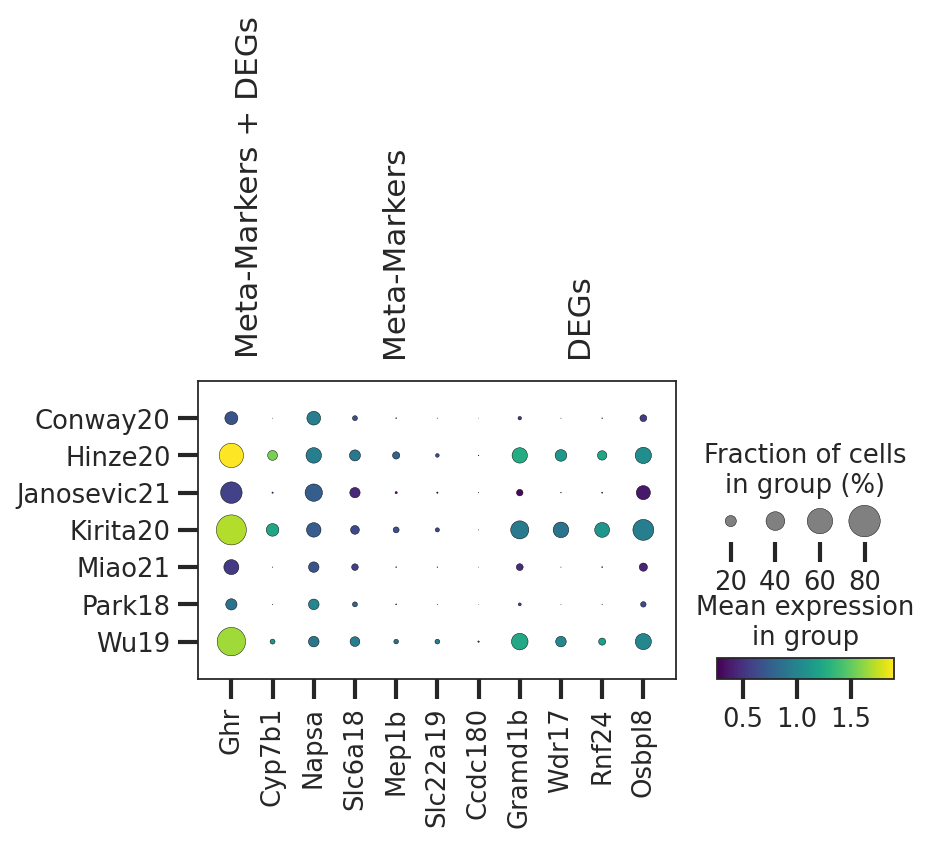

In [17]:
sc.pl.dotplot(atlas[atlas.obs.Origin != 'Dumas20'], new_dict, groupby='Origin', mean_only_expressed=True, expression_cutoff=0.0, cmap='viridis',
             save = 'PTS3T2_MMvsDGEs.svg')

In [26]:
sns.set_style("ticks")
df = atlas[atlas.obs.Predicted_Celltype_all == 'PTS3T2'].obs.groupby('Origin').apply(len).to_frame()
df[0] = (df[0] * 100) / atlas.obs.groupby('Origin').apply(len).to_frame()[0]
ax = sns.barplot(x=df.index, y=0, data=df)
plt.xticks(rotation=90)
plt.savefig("/exports/humgen/cnovellarausell/KidneyAtlas/PTS3T2_barplot.svg", bbox_inches="tight")
plt.close()

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
df

,0
Origin,
Conway20,6
Hinze20,2468
Janosevic21,66
Kirita20,1815
Miao21,88
Park18,29
Wu19,6
